Connect to your google drive in order to use files from database:

---



---



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Loading the Modules for the Code, just run this part:

---



In [2]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from nltk.stem.porter import *
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

Getting the file from Google Drive, might have to change file location, You can 
change what files are in the folder to look at certain timeframes:

---


In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("/content/drive/MyDrive/Stage2Clean") if isfile(join("/content/drive/MyDrive/Stage2Clean", f))]
fileOpen = "/content/drive/MyDrive/Stage2Clean/"
temp = fileOpen + onlyfiles[0] 
fileLoc = pd.read_csv(temp)
allFiles = fileLoc
for i in range(1,len(onlyfiles)):
  temp = fileOpen + onlyfiles[i] 
  fileLoc = pd.read_csv(temp)
  allFiles = allFiles.append(fileLoc)
allFiles

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,tidy_state,tidy_coc,tidy_address,tidy_incident_characteristics,tidy_notes,tidy_participant_age_group,tidy_participant_gender,tidy_participant_name,tidy_participant_relationship,tidy_participant_status,tidy_participant_type
0,112359,2014-03-01,Tennessee,Memphis,NaN,1,0,http://www.gunviolencearchive.org/incident/112359,http://www.wave3.com/story/24901150/stepbrothe...,False,9.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)",35.0029,NaN,-89.9369,NaN,NaN,0:24,0:Adult 18+|1:Adult 18+,0:Male|1:Male,0:Demetrius Ray,NaN,0:Killed|1:Unharmed,0:Victim|1:Subject-Suspect,http://www.wave3.com/story/24901150/stepbrothe...,85.0,33.0,tennesse,memphi,NaN,shot dead murder accident suicid,NaN,adult adult,male male,demetriu ray,NaN,kill unharm,victim subject suspect
1,111137,2014-03-01,Oklahoma,Oklahoma City,119 E. California St.,1,0,http://www.gunviolencearchive.org/incident/111137,http://www.koco.com/news/victim-of-fatal-oklah...,False,5.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)|Bar/...",35.4656,NaN,-97.5098,NaN,Club Social,0:30,0:Adult 18+|1:Adult 18+,0:Male,0:Zachary Bowie,NaN,0:Killed|1:Unharmed,0:Victim|1:Subject-Suspect,http://kfor.com/2014/03/01/shooting-in-brickto...,99.0,48.0,oklahoma,oklahoma citi,E california St,shot dead murder accident suicid bar club inci...,club social,adult adult,male,zachari bowi,NaN,kill unharm,victim subject suspect
2,111444,2014-03-01,California,Oakland,San Pablo and 23rd,0,1,http://www.gunviolencearchive.org/incident/111444,http://www.ktvu.com/news/news/crime-law/woman-...,False,13.0,NaN,NaN,Shot - Wounded/Injured,37.8139,NaN,-122.2740,NaN,NaN,NaN,0:Adult 18+,0:Male,NaN,NaN,0:Injured,0:Victim,http://www.ktvu.com/news/news/crime-law/woman-...,18.0,9.0,california,oakland,san pablo and rd,shot wound injur,NaN,adult,male,NaN,NaN,injur,victim
3,112272,2014-03-01,California,Tujunga,Plainview Avenue,1,0,http://www.gunviolencearchive.org/incident/112272,http://ktla.com/2014/03/05/fatal-gunshot-victi...,False,28.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)",34.2632,NaN,-118.2980,NaN,deceased for 3 days until found (3/4/14),NaN,0:Adult 18+,0:Male,NaN,NaN,0:Killed,0:Victim,http://ktla.com/2014/03/05/fatal-gunshot-victi...,39.0,25.0,california,tujunga,plainview avenu,shot dead murder accident suicid,deceas for day until found,adult,male,NaN,NaN,kill,victim
4,111134,2014-03-01,Ohio,Dayton,2027 Nicholas Road,0,1,http://www.gunviolencearchive.org/incident/111134,http://www.whio.com/news/news/crime-law/police...,False,10.0,NaN,NaN,Shot - Wounded/Injured|Bar/club incident - in ...,39.7325,NaN,-84.2284,NaN,19th Hole. Confrontation in bar carries out i...,0:45,0:Adult 18+,0:Male,0:Jerry Henderson,NaN,0:Injured,0:Victim|1:Subject-Suspect,http://wdtn.com/2014/03/01/man-shot-in-neck-at...,39.0,5.0,ohio,dayton,nichola road,shot wound injur bar club incid in or around e...,th hole confront in bar carri out into park lo...,adult,male,jerri henderson,NaN,injur,victim subject suspect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5087,716109,2016-11-30,New York,Bronx,Vyse Ave,0,0,http://www.gunviolencearchive.org/incident/716109,http://www.nydailynews.com/new-york/nyc-crime/...,False,15.0,0::Unknown,0::Unknown,Non-Shooting Incident||Home Invasion||Home Inv...,40.8368,Foxhurst,-73.8860,1.0,HI; no shots fired; 4 perps 69yo woman's apt; ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.nydailynews.com/new-york/nyc-crime/...,79.0,32.0,new york,bronx,vyse ave,non shoot incid home inv

Creating Training and Testing Sets

---



In [4]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from pandas import DataFrame 

FeatColumns = ["n_killed","n_injured","date","tidy_coc","tidy_address","tidy_incident_characteristics","tidy_participant_age_group","tidy_participant_gender","tidy_participant_type"]
df = DataFrame(allFiles, columns=FeatColumns) 

df = df['n_killed'].map(str) + "," + df['n_injured'].map(str) + ","+ df['date'].map(str) + "," + df['tidy_coc'].map(str) + ',' + df['tidy_address'].map(str) + ',' + df['tidy_incident_characteristics'].map(str) + ',' + df['tidy_participant_age_group'].map(str) + ',' + df['tidy_participant_gender'].map(str) + ',' + df['tidy_participant_type'].map(str)

X = df # Features
y = allFiles["tidy_state"] # Target variable

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

Creating Word Level tf-idf

---



In [5]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(X)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xvalid_tfidf =  tfidf_vect.transform(X_test)

Creating a Table for the Classifiers

---



In [ ]:
tableForClassifier = []
def train_model(name,classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    temp = name, metrics.accuracy_score(predictions, y_test), metrics.precision_score(predictions, y_test, average='macro'), metrics.recall_score(predictions, y_test, average='macro'), metrics.f1_score(predictions, y_test, average='macro')
    tableForClassifier.append(temp)
    return metrics.accuracy_score(predictions, y_test)

Classifiers

---



In [ ]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model("Naive Bayes",naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NB, WordLevel TF-IDF:  0.6136098130841121


In [ ]:
from sklearn.model_selection import cross_validate
cv = cross_validate(naive_bayes.MultinomialNB(), xtrain_tfidf, y_train, cv=10)
print(cv['test_score'])
print(cv['test_score'].mean())

[0.6293635  0.63654907 0.63733717 0.63599277 0.63515831 0.63321126
 0.63260859 0.63826434 0.63478745 0.6336115 ]
0.6346883946571666


In [ ]:
# RF on Word Level TF IDF Vectors
accuracy = train_model("Bagging",ensemble.RandomForestClassifier(), xtrain_tfidf, y_train, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

RF, WordLevel TF-IDF:  0.7002113929684023


In [ ]:
cv = cross_validate(ensemble.RandomForestClassifier(), xtrain_tfidf, y_train, cv=10)
print(cv['test_score'])
print(cv['test_score'].mean())

In [ ]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model("Boosting",xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), y_train, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

Xgb, WordLevel TF-IDF:  0.7746161548731643


In [ ]:
cv = cross_validate(xgboost.XGBClassifier(), xtrain_tfidf, y_train, cv=10)
print(cv['test_score'])
print(cv['test_score'].mean())

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
accuracy = train_model("K-Neighbor",KNeighborsClassifier(), xtrain_tfidf.tocsc(), y_train, xvalid_tfidf.tocsc())
print("K-Neighbor, WordLevel TF-IDF: ", accuracy)

K-Neighbor, WordLevel TF-IDF:  0.6446651090342679


In [ ]:
cv = cross_validate(KNeighborsClassifier(), xtrain_tfidf, y_train, cv=10)
print(cv['test_score'])
print(cv['test_score'].mean())

Table for the classifiers

---





In [ ]:
from IPython.display import HTML, display
import tabulate
finalClassTable = display(HTML(tabulate.tabulate(tableForClassifier, tablefmt='html', headers=["Classifier","Accuracy","Percision","Recall","F-Measure"])))
finalClassTable

Classifier,Accuracy,Percision,Recall,F-Measure
Naive Bayes,0.61361,0.353026,0.704811,0.391264
Bagging,0.700211,0.594684,0.710497,0.634452
Boosting,0.774616,0.714512,0.856175,0.768556
K-Neighbor,0.644665,0.579874,0.646993,0.591755


Testing K-means

---



---



In [ ]:
from sklearn.metrics import calinski_harabasz_score

for i in range(2,8):
    kmeans = Kmeans(n_clusters = i, random_state=123).fit(xtrain_tfidf)
    score = calinski_harabasz_score(xtrain_tfidf_tfidf.toarray(),kmeans.labels_)
    print(score,i)


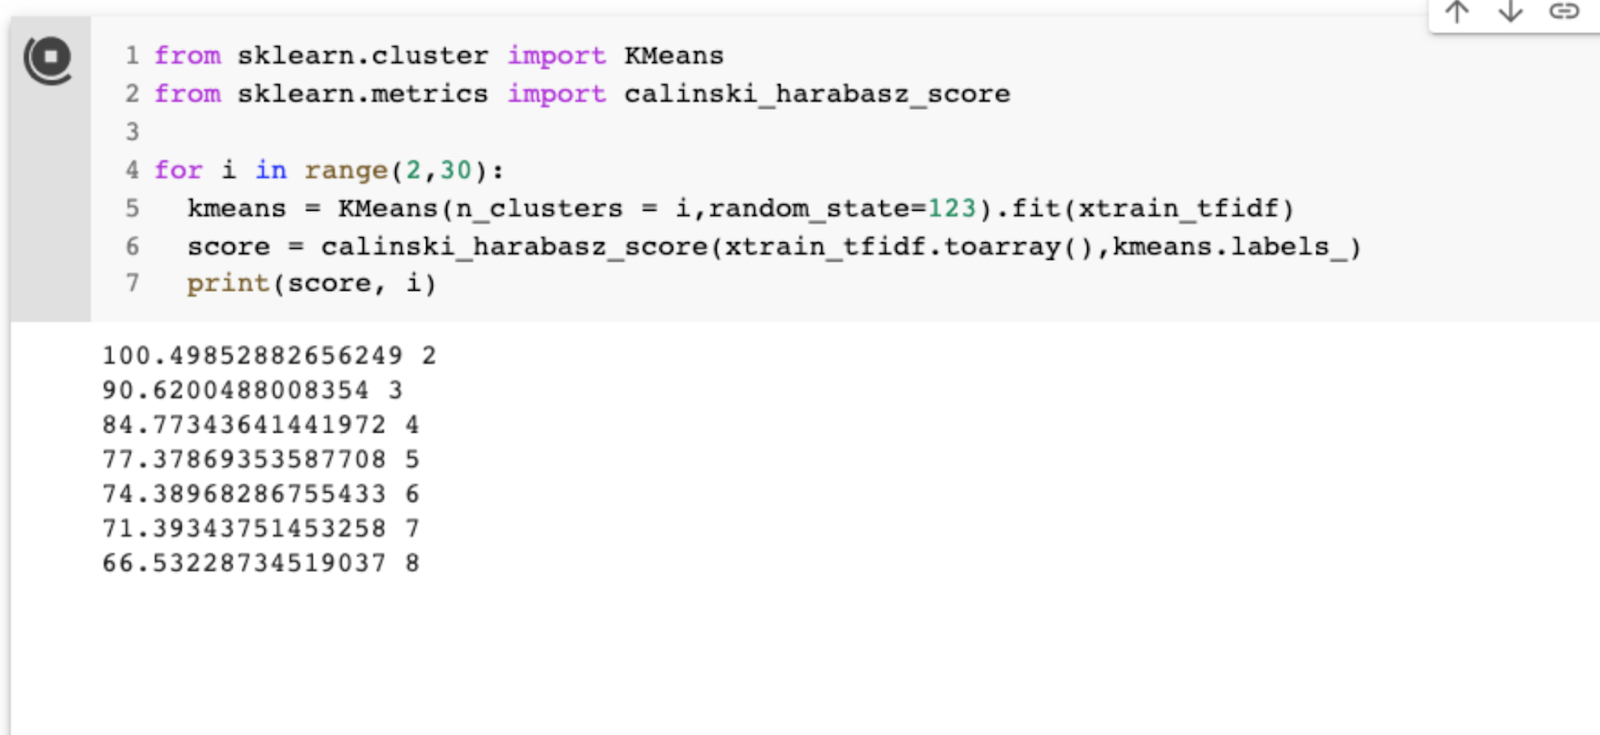

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(xtrain_tfidf)
    distortions.append(kmeanModel.inertia_)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

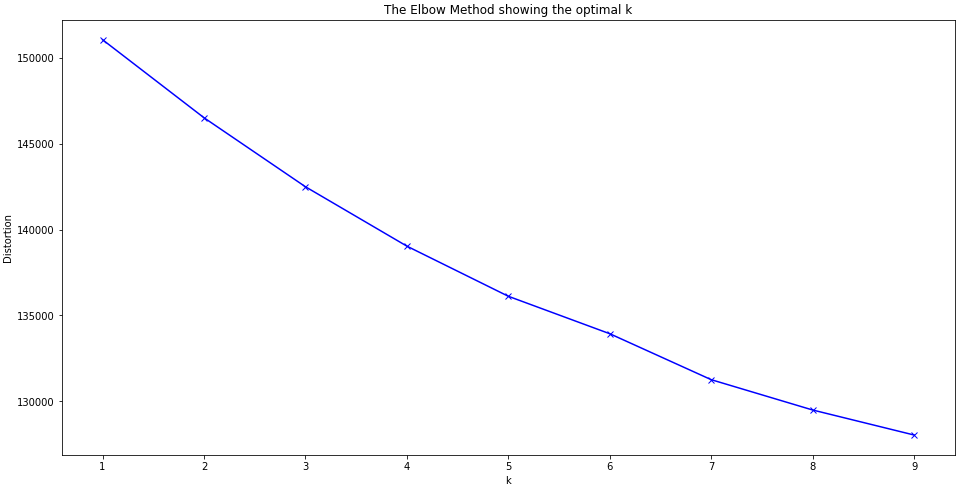

Creating Maps

---



---



In [6]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [7]:
unique_list = [] 
  
# traverse for all elements 
for x in y: 
    # check if exists in unique_list or not 
    if x not in unique_list: 
        unique_list.append(x) 

In [8]:
import umap
trans = umap.UMAP(n_neighbors=5, random_state=42).fit(xtrain_tfidf)

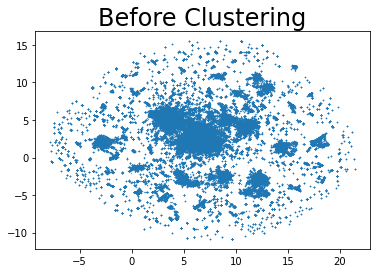

In [ ]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s= 0.1, cmap='Rainbow')
plt.title('Before Clustering', fontsize=24);

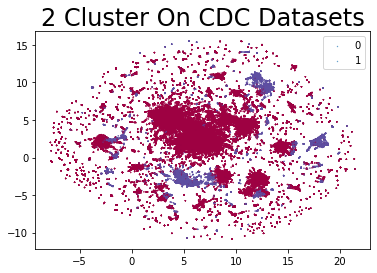

In [12]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(xtrain_tfidf)
y_kmeans = kmeans.predict(xtrain_tfidf)

centroids = kmeans.cluster_centers_
label = kmeans.fit_predict(xtrain_tfidf)
u_labels = np.unique(label)

for i in u_labels:
  plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=y_kmeans, s= 0.1, cmap='Spectral',label = i)
plt.legend()
plt.title('2 Cluster On CDC Datasets', fontsize=24);

In [ ]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(xtrain_tfidf)
y_kmeans = kmeans.predict(xtrain_tfidf)

plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=y_kmeans, s= 0.1, cmap='Spectral')
plt.title('10 Cluster On CDC Datasets', fontsize=24);

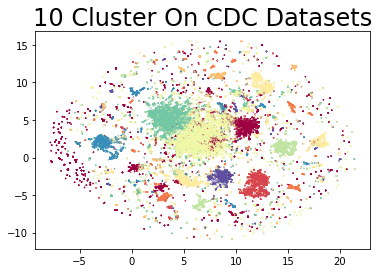

In [ ]:
plt.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], c=y_kmeans, s= 0.1, cmap='Spectral')
plt.title('10 Cluster On CDC Datasets', fontsize=24);